# Importando bibliotecas

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Lendo dados

In [27]:
df = pd.read_csv('../data/processed/sample_df_processed.csv')
df['speed'] = df['speed'].astype('str')
df['feed'] = df['feed'].astype('str')

In [28]:
df.dtypes

vibration_x    float64
vibration_y    float64
vibration_z    float64
machine         object
operation       object
description     object
speed           object
feed            object
duration         int64
result           int64
dtype: object

# Separando dados em treino e teste

In [29]:
X = df.drop(columns=["result"])  
y = df["result"]

# Separando o dataset em treino e teste mantendo a proporção das classes e com uma divisão de 70% para treino e 30% para teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Pre-processamento dos dados

In [30]:
# DIVISÃO ENTRE COLUNAS CATEGORICAS E NUMERICAS
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [31]:
# NORMALIZAR COLUNAS NUMERICAS
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# CODIFICAR COLUNAS CATEGORICAS
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [32]:
# PRE-PROCESSAMENTO DOS DADOS 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Criando pipeline utilizando preprocessamento dos dados e utilizando a algoritmo de regressão logistica

In [33]:
# CRIANDO ESCALA PARA PESO DAS CLASSES
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]

# CRIANDO O PIPELINE COM OS DADOS PRE-PROCESSADOS E O CLASSIFICADOR
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight
    ))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

## Criando matriz de confusão

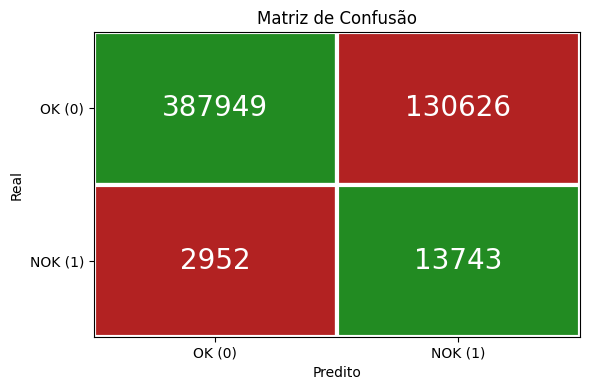

In [34]:
cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

# Plotar manualmente com cores nos quadrantes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=3))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

# Eixos e rótulos
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

# Ajustes de grade
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

1. Observa-se para os casos OK que com o peso do balanceamento há uma distribuição de resultados mas com mais VP;
2. Para casos NOK há uma melhora comparado a outros modelos tendo mais casos de VP do que FN.

## Avaliando métricas

In [36]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision recall f1-score
0            99.24  74.81    85.31
1             9.52  82.32    17.07
accuracy     75.04  75.04    75.04


Como esperando no relatório das métricas observamos:
1. A classe OK tem 99,24% das previsões corretas detectadas de maneira correta pelo modelo.Recall de 74,81% o que mostra que  boa parte dos casos OK foram detecdatos. Com resultados trazem um f1-score relativamente alto;
2. A classe NOK tem apenas 9,52% de previsões corretas. Recall de 82,32% que mostra que o modelo ainda detecta bem os casos nok. Como resultado desse equilibrio traz um f1-score baixo.
3. A acurácia tem um valor bom devido ao desbalaceamento das classes.

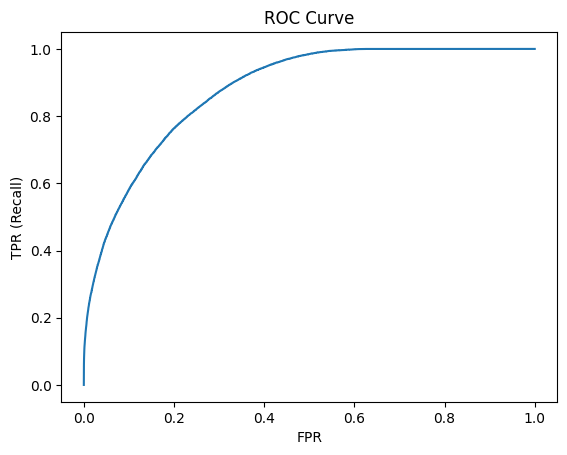

AUC: 0.88


In [37]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.show()
print(f"AUC: {auc:.2f}")



Pela curva ROC observamos:
1. Curva cresce rapidamente o que mostra boa distribuição entre as classes
2. Curva com bom resultado mas o desempenho real pelo indicadores estão abaixo
3. Encontrar a divisão adequada tende a melhorar o desempenho do modelo.
4. Valor de AUC próximo ao ideal (0,90)

# Otimizar resultado a partir da curva ROC

## Otimização F1-score

In [41]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_threshold_f1 = thresholds_pr[np.argmax(f1)]

print(f"Threshold ideal (F1-score máximo): {optimal_threshold_f1:.4f}")

Threshold ideal (F1-score máximo): 0.8404


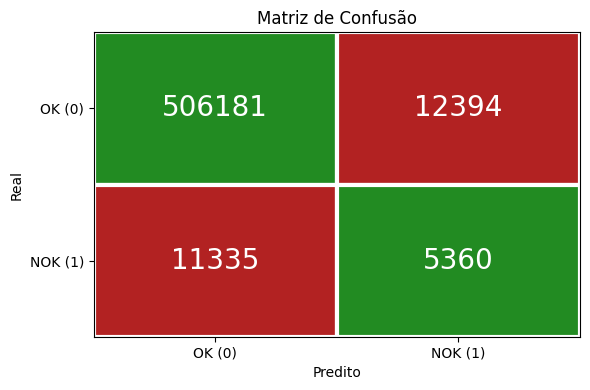

In [42]:
y_pred = (y_proba >= optimal_threshold_f1).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

# Plotar manualmente com cores nos quadrantes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=3))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

# Eixos e rótulos
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

# Ajustes de grade
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [43]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision recall f1-score
0            97.81  97.61    97.71
1            30.19  32.11    31.12
accuracy     95.57  95.57    95.57


1. Com a otimização para os casos OK temos uma leve queda de precisão com um aumento significativo de recall e f1-score;
2. Para os casos NOK a precisão e o f1-score aumentam bastante mas o recall tem uma alta queda;
3. Com o ajuste há uma melhoria impacta diretamente nos valores de acurácia geral.

## Otimização Youden

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]

print(f"Threshold ideal (Youden): {optimal_threshold:.4f}")


Threshold ideal (Youden): 0.4553


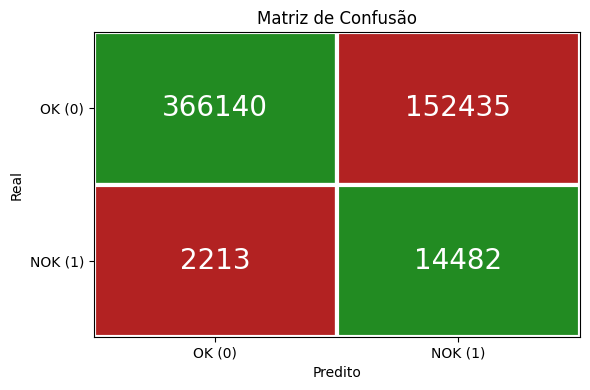

In [45]:
y_pred = (y_proba >= optimal_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

# Plotar manualmente com cores nos quadrantes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=3))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

# Eixos e rótulos
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

# Ajustes de grade
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [46]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision recall f1-score
0            99.40  70.61    82.56
1             8.68  86.74    15.77
accuracy     71.11  71.11    71.11


1. Com essa otimização observa-se para os casos OK um aumento bem baixo na precisão, e uma queda em recall e f1-score;
2. Para os casos NOK há uma queda na precisão e f1-score e uma melhoria no recall;
3. Avaliando a acurácia geral do modelo há uma queda.

# 

In [47]:
import shap

model = pipeline.named_steps["classifier"]


c:\Users\Leonardo\Python\PROJETOS FACULDADE\tcc_machine_learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
X_train_transformed = pipeline.named_steps["preprocessor"].transform(X_train)
X_test_transformed = pipeline.named_steps["preprocessor"].transform(X_test)


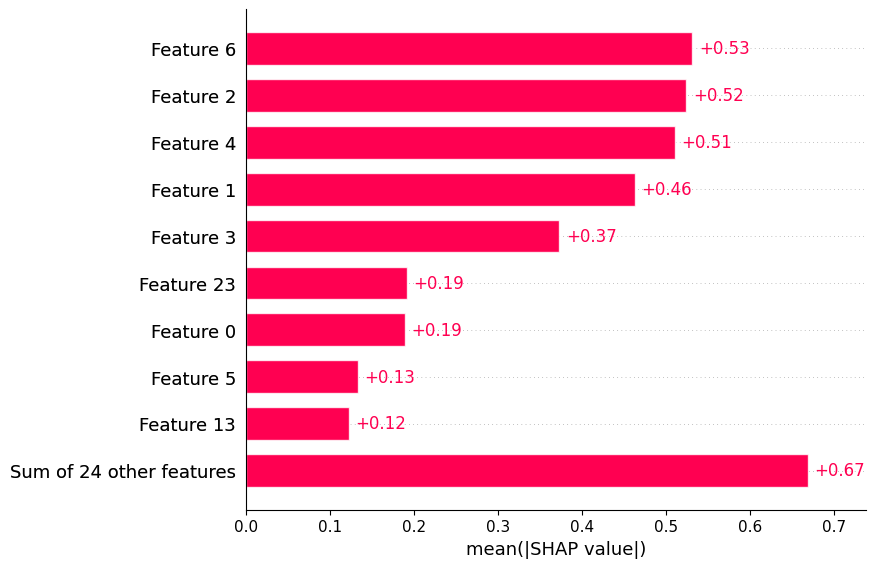

In [50]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_train_transformed)


# Índices booleanos diretamente no array
nok_mask = np.array(y_train == 1)
shap_values_nok = shap_values[nok_mask]

# Visualiza as features mais importantes para a classe NOK
shap.plots.bar(shap_values_nok)


In [54]:
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

print("Shape do transformado:", X_train_transformed.shape)
print("Nomes retornados:", len(feature_names))


Shape do transformado: (1248961, 33)
Nomes retornados: 33


In [55]:
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()

X_train_transformed_df = pd.DataFrame(
    X_train_transformed,
    columns=feature_names
)

100%|===================| 1248200/1248961 [26:51<00:00]        

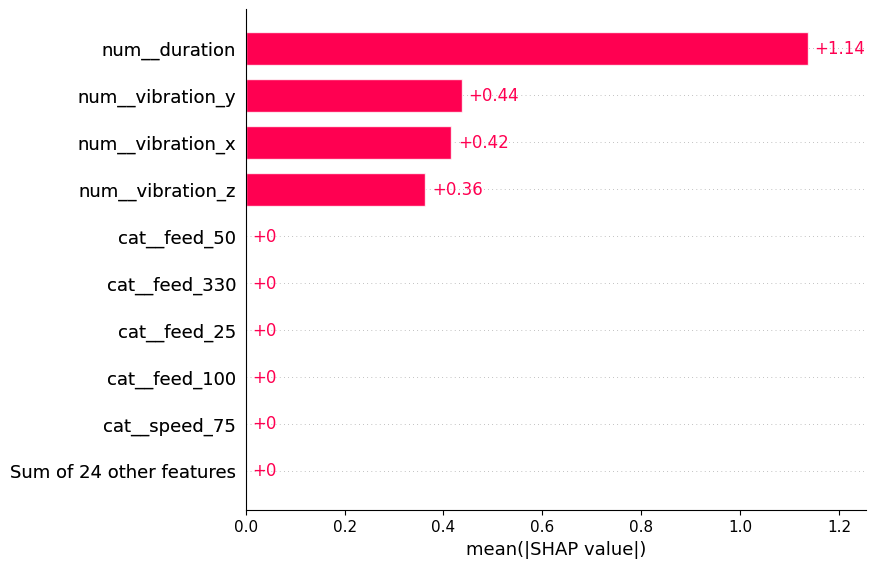

In [56]:
explainer = shap.Explainer(model, X_train_transformed_df)
shap_values = explainer(X_train_transformed_df)

nok_mask = np.array(y_train == 1)
shap_values_nok = shap_values[nok_mask]

shap.plots.bar(shap_values_nok)

In [61]:
mean_shap_values = np.abs(shap_values_nok.values).mean(axis=0)

shap_df = pd.DataFrame({
    "feature": X_train_transformed_df.columns,
    "mean_abs_shap": mean_shap_values
}).sort_values(by="mean_abs_shap", ascending=False)

In [ ]:
shap_df()

,feature,mean_abs_shap
3,num__duration,1.137433
1,num__vibration_y,0.437619
0,num__vibration_x,0.416208
2,num__vibration_z,0.363162
4,cat__machine_M01,0.000000
5,cat__machine_M02,0.000000
6,cat__machine_M03,0.000000
7,cat__operation_OP00,0.000000
8,cat__operation_OP01,0.000000
9,cat__operation_OP02,0.000000
